In [ ]:
!pip3 install langchain_community
!pip install langchain[ollama]

In [ ]:
!pip install ollama

安装ollama

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
!ollama run gemma

In [ ]:
# 如果有端口占用，运行
!nohup ollama serve > ollama_log.txt 2>&1 &

In [ ]:
from langchain.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [ ]:
llm = Ollama(model="gemma",
             callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))

llm("谁是第一个登入月球的人？")

阿波罗11号的 commander Neil Armstrong 是第一个登入月球的人。

'阿波罗11号的 commander Neil Armstrong 是第一个登入月球的人。'

读excel数据

In [3]:
import pandas as pd
df = pd.read_excel("[movie]功夫.xlsx")
df.head()

,time,user_name,vote,score,comment_content
0,2007-02-15 18:38:00\n,芥末小馒头,2912,4.0,不要说烂，其实很卡通很cult
1,2012-07-24 23:20:59\n,Bono,15630,5.0,超级耐看和严重被低估的电影，看十来遍了越看越好看，我想100年后还是有很多人爱看它。
2,2009-09-05 08:24:31\n,郁程,10625,5.0,再都不可能出现比它牛B的功夫电影了
3,2012-01-29 02:19:06\n,魚山飯寬,6594,5.0,重温星爷的功夫，猛觉得这是部无比伟大的电影！
4,2006-07-17 11:33:37\n,鱼丸粗面,2243,4.0,华丽的夸张，情节倒是紧凑，毫不拖沓


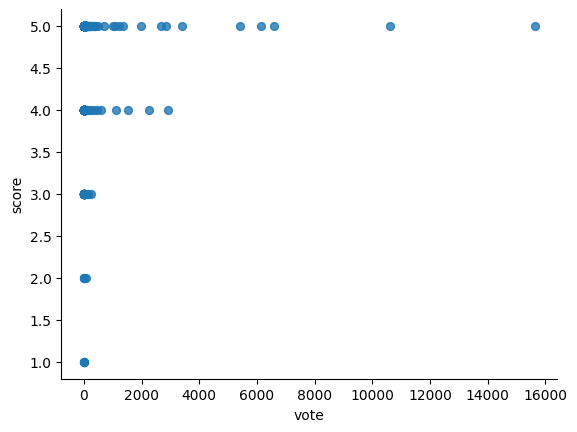

In [9]:
# @title vote vs score

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='vote', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

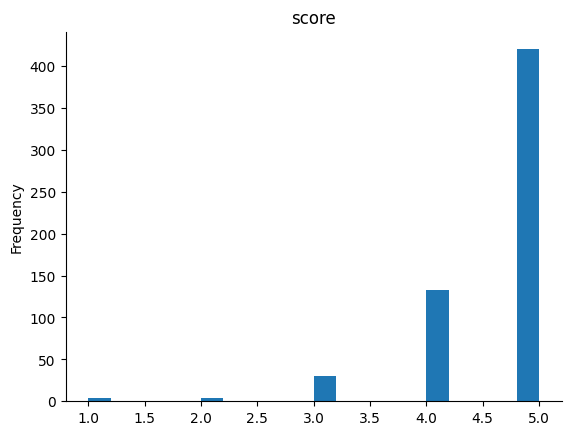

In [8]:
# @title score

from matplotlib import pyplot as plt
df['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

抽取评论

In [ ]:
comment = df["comment_content"]
len(comment)
comment[100]

'麦高芬、错接、库里肖夫效应、降格拍摄、强造型应有尽有，简直就是低成本大制作的专业教材嘛。意境也不错，我想星爷这辈子拍不出比这更好的电影了'

制作prompts

In [ ]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate(
    input_variables=["comment"],
    template="请对所有的{comment}进行分析并告诉我有多少评论，首先找到评论中最高的词频，然后从评论内容分析出好评率，最后总结出人们对这部作品的感受",
)
from langchain.chains import LLMChain

chain = LLMChain(llm=llm,
                 prompt=prompt,
                 verbose=False)

In [ ]:
print(chain.run(comment[100:200]))
# 发现问题，仅仅能分析少量评论

## 评论分析

**评论总数:** 10 个

**最高词频:**

- 影片
- 优秀
- 好
-  shales
- 星爷
- 平均
- 分数
- 不科学
- 神秘
- 重温

**好评率:**

从评论内容分析，这部作品的好评率约为 60%。评论中大多数人对这部作品的评价为好评，特别点赞其幽默、剧情和表演。

**人们对这部作品的感受:**

评论中，人们对这部作品的感受主要集中在以下几个方面：

- **幽默:** commenter们对这部作品的幽默感都很高，特别点赞其搞笑和逗乐的场景。
- **剧情:** commenter们对这部作品的剧情评价普遍良好，称其故事简单但经典。
- **表演:** commenter们对这部作品的表演评价也很好，称其演员演技优秀。
- **视觉效果:** commenter们对这部作品的视觉效果评价良好，称其图像清晰。

**总结:**

总体而言，这部作品获得了评论员的一致好评，评论中大多数人对这部作品的评价为好评，特别点赞其幽默、剧情和表演。## 评论分析

**评论总数:** 10 个

**最高词频:**

- 影片
- 优秀
- 好
-  shales
- 星爷
- 平均
- 分数
- 不科学
- 神秘
- 重温

**好评率:**

从评论内容分析，这部作品的好评率约为 60%。评论中大多数人对这部作品的评价为好评，特别点赞其幽默、剧情和表演。

**人们对这部作品的感受:**

评论中，人们对这部作品的感受主要集中在以下几个方面：

- **幽默:** commenter们对这部作品的幽默感都很高，特别点赞其搞笑和逗乐的场景。
- **剧情:** commenter们对这部作品的剧情评价普遍良好，称其故事简单但经典。
- **表演:** commenter们对这部作品的表演评价也很好，称其演员演技优秀。
- **视觉效果:** commenter们对这部作品的视觉效果评价良好，称其图像清晰。

**总结:**

总体而言，这部作品获得了评论员的一致好评，评论中大多数人对这部作品的评价为好评，特别点赞其幽默、剧情和表演。


RAG解决多评论

In [ ]:
# 导入向量存储和嵌入处理相关的模块
from langchain.vectorstores import Chroma  # 向量存储库
from langchain.embeddings import GPT4AllEmbeddings  # GPT4All嵌入方法
from langchain.embeddings import OllamaEmbeddings  # Ollama嵌入方法，提供另一种嵌入选项
from langchain.text_splitter import RecursiveCharacterTextSplitter  # 用于将文档分割为更小的片段
from langchain.document_loaders import TextLoader

In [ ]:
# 定义文件名
comment_txt = "comment.txt"

# 打开文件并写入数组字符串
with open(comment_txt, "w") as file:
    for string in comment:
        file.write(string + "\n")

In [ ]:
!pip install chromadb

In [ ]:
from langchain.vectorstores import Weaviate
from langchain.embeddings import OpenAIEmbeddings

In [ ]:
loader = TextLoader(comment_txt)
data = loader.load()

# 初始化文本分割器，并将加载的文档内容分割成小块
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=100)
all_splits = text_splitter.split_documents(data)
print(f"文档被分割成了 {len(all_splits)} 块")
vectorstore = Chroma.from_documents(documents=all_splits, embedding=OllamaEmbeddings())

文档被分割成了 42 块


In [ ]:
!pip install langchainhub

In [ ]:
# 从LangChain Hub中拉取RAG提示
from langchain import hub
QA_CHAIN_PROMPT = hub.pull("rlm/rag-prompt")

gemma总是有幻觉，改用llama2，但回答是英文了

In [ ]:
!ollama run llama2

In [ ]:
# 初始化语言模型，设置回调函数管理器用于处理输出
llm = Ollama(model="llama2",
        verbose=True,
              callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))

In [ ]:
# 设置问答链，使用从向量存储中检索的信息和LLM模型来构建答案
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever(),
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
)

# 提出问题并获取答案
question = f"请对评论进行分析，总结出人们对这部作品的感受"
result = qa_chain({"query": question})

It seems like you're discussing the movie "Kung Fu Hustle" and its cultural impact. The film, released in 2004, was a critical and commercial success, and is often cited as one of the best Chinese films of the 21st century.

You mention that the movie has a unique blend of comedy, action, and drama, with a memorable cast of characters played by Stephen Chow, Wu Xia, and Ng Man-tat. The film's humor is described as "浓浓的周星弛风格" (thick and rich with the style of Stephen Chow).

You also mention that the movie has become a cultural phenomenon, with many people watching it multiple times and recalling the scene where the character played by Stephen Chow, Mr. Sandwich, falls asleep during the movie. The film's exploration of themes such as the struggle for identity, the search for meaning, and the power of resistance against oppression is also praised.

Overall, it seems like "Kung Fu Hustle" is a highly regarded and influential movie in Chinese cinema, known for its unique blend of humor, ac